# 06b: Transformer_PatchTST_Modelling

## Overview



## 1. Import Necessary Libraries

In [1]:
import sys
import os
import time
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
from transformers import PatchTSTConfig, PatchTSTForClassification

## 2. Mount Google Drive

This section mounts the Google Drive to access files directly within the Colab environment.

In [2]:
from google.colab import drive

# Mount Google drive
drive.mount('/content/drive')

# Base file path
basePath = 'drive/MyDrive/Colab Notebooks/AAI-590-01_02/AAI590_CapstoneProject'

Mounted at /content/drive


## 4. Load Transformer Feature Data

In [3]:
# Note: use below code if running in the local machine
# transformer_data_path = r'../data/processed/transformer_features_data_df.csv'

# Note: use below code if running in the Google colab
transformer_data_path = os.path.join(basePath, 'data/features/transformer_features_data_df.csv')

# Load static data
transformer_data_df = pd.read_csv(transformer_data_path)
display(transformer_data_df.head())

,RecordID,TimeBin,RespRate,Urine,pH,HCT,NIDiasABP,NIMAP,NISysABP,HR_mask,...,MechVent_mask,HR_bin_enc,MAP_bin_enc,GCS_bin_enc,Gender,ICUType,In-hospital_death,Height_missing,Weight_missing,AgeBMI_token_encoded
0,132539,0-60,-0.062473,1.314870,-0.01841,0.415878,0.330632,1.115615,1.523818,1.0,...,0.0,1.0,2.0,0.0,0,4,0,1,1,17
1,132539,60-120,-0.405697,-0.384400,-0.01841,0.415878,0.366022,0.789919,0.887245,1.0,...,0.0,0.0,2.0,0.0,0,4,0,1,1,17
2,132539,120-180,-0.062473,-0.128596,-0.01841,0.415878,-0.341788,-0.001107,0.293111,1.0,...,0.0,1.0,2.0,0.0,0,4,0,1,1,17
3,132539,180-240,0.109139,-0.018966,-0.01841,0.415878,-0.341788,-0.105833,0.102140,1.0,...,0.0,1.0,2.0,0.0,0,4,0,1,1,17
4,132539,240-300,0.280751,-0.329585,-0.01841,0.415878,-0.341788,-0.210558,-0.088832,1.0,...,0.0,1.0,2.0,0.0,0,4,0,1,1,17


## Prepare Model Input

### Build Temporal Tensors

In [4]:
def extract_patient_Xy(df, record_col='RecordID', time_col='TimeBin', label_col='In-hospital_death'):
    patient_tensors = []
    labels = []

    for record_id, group in df.groupby(record_col):
        group_sorted = group.sort_values(by=time_col)

        if len(group_sorted) != 48:
            raise ValueError(f"Patient {record_id} has {len(group_sorted)} time steps. Expected 48.")

        y_val = group_sorted[label_col].iloc[0]
        features = group_sorted.drop(columns=[record_col, time_col, label_col]).values

        X_tensor = torch.tensor(features, dtype=torch.float32)
        patient_tensors.append(X_tensor)
        labels.append(y_val)

    return torch.stack(patient_tensors), torch.tensor(labels, dtype=torch.long)

X, y = extract_patient_Xy(transformer_data_df)
print(X.shape, y.shape)

torch.Size([3997, 48, 40]) torch.Size([3997])


### Handle Class Imbalance

In [5]:
Counter(y.tolist())

Counter({0: 3443, 1: 554})

In [6]:
# T-SMOTE Function: n_neighbors = 3  for more contextual similarity
def t_smote(X, y, n_neighbors=3):
    # Determine class imbalance
    class_counts = Counter(y.tolist())
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)
    imbalance = class_counts[majority_class] - class_counts[minority_class]

    window_size = X.shape[1]  # Use full time window: 48
    n_synthetic = imbalance  # To equalize classes

    X_minority = X[y == minority_class]
    reshaped_windows = X_minority.reshape(-1, window_size * X.shape[2])
    nn = NearestNeighbors(n_neighbors=n_neighbors + 1).fit(reshaped_windows)
    synthetic_series = []

    for _ in range(n_synthetic):
        idx = np.random.randint(len(reshaped_windows))
        _, neighbors = nn.kneighbors([reshaped_windows[idx]])
        neighbor = reshaped_windows[neighbors[0][1]]  # Skip self (index 0)

        alpha = np.random.rand()
        synthetic = alpha * reshaped_windows[idx] + (1 - alpha) * neighbor
        synthetic_series.append(synthetic.reshape(window_size, X.shape[2]))

    X_synth = np.array(synthetic_series)
    y_synth = np.array([minority_class] * len(synthetic_series))

    return np.concatenate([X, X_synth]), np.concatenate([y, y_synth])

# Run T-SMOTE
X_aug, y_aug = t_smote(X, y)
print("Augmented X shape: ", X_aug.shape)
print("Augmented y shape: ", y_aug.shape)

Augmented X shape:  (6886, 48, 40)
Augmented y shape:  (6886,)


In [7]:
Counter(y_aug.tolist())

Counter({0: 3443, 1: 3443})

### Split Data

In [9]:
def time_series_balanced_split(X, y, train_ratio=0.6, val_ratio=0.2):
    # Group indices by class
    class_indices = defaultdict(list)
    for idx, label in enumerate(y):
        class_indices[label].append(idx)

    X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []

    for label, indices in class_indices.items():
        n_total = len(indices)
        n_train = int(n_total * train_ratio)
        n_val = int(n_total * val_ratio)

        sorted_indices = sorted(indices)  # Preserve time order
        train_idx = sorted_indices[:n_train]
        val_idx = sorted_indices[n_train:n_train + n_val]
        test_idx = sorted_indices[n_train + n_val:]

        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])

    return (
        np.array(X_train), np.array(y_train),
        np.array(X_val), np.array(y_val),
        np.array(X_test), np.array(y_test)
    )

X_train, y_train, X_val, y_val, X_test, y_test = time_series_balanced_split(X_aug, y_aug)
print("Train:", Counter(y_train), "| Shape:", X_train.shape)
print("Val:", Counter(y_val), "| Shape:", X_val.shape)
print("Test:", Counter(y_test), "| Shape:", X_test.shape)

Train: Counter({np.int64(0): 2065, np.int64(1): 2065}) | Shape: (4130, 48, 40)
Val: Counter({np.int64(0): 688, np.int64(1): 688}) | Shape: (1376, 48, 40)
Test: Counter({np.int64(0): 690, np.int64(1): 690}) | Shape: (1380, 48, 40)


## PatchTST

In [10]:
config = PatchTSTConfig(
    num_input_channels=40,       # You have 40 features per time step
    context_length=48,           # Full 48-hour ICU trace per patient
    patch_length=1,              # Each patch = 1 hourly bin
    patch_stride=1,              # No overlap — all 48 bins are used
    use_cls_token=True,
    num_targets=2                # Binary outcome: survival vs mortality
)

model = PatchTSTForClassification(config)

In [11]:
# Define ICU Dataset class
class ICUTimeSeriesDataset(Dataset):
    def __init__(self, patch_tensor, targets):
        self.X = patch_tensor  # shape: [N, W, L, F]
        self.y = targets       # binary labels

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        x = x.reshape(x.shape[0], -1)  # [patches, features × steps]
        return x, y

In [12]:
# Training + Evaluation Class
class PatchTST_Trainer:
    def __init__(self, model,
                 criterion=torch.nn.CrossEntropyLoss(),
                 optimizer_class=torch.optim.AdamW,
                 learning_rate=1e-4):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer_class(model.parameters(), lr=learning_rate)
        self.epoch_losses = []
        self.epoch_aurocs = []

    def train(self, train_x, train_y, val_x, val_y, epochs=50, batch_size=32):
        device = next(self.model.parameters()).device
        train_loader = DataLoader(ICUTimeSeriesDataset(train_x, train_y), batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(ICUTimeSeriesDataset(val_x, val_y), batch_size=batch_size, shuffle=False)

        for epoch in range(epochs):
            self.model.train()
            running_loss = 0.0

            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self.model(past_values=batch_x, target_values=batch_y)
                loss = outputs.loss
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(train_loader)
            self.epoch_losses.append(avg_loss)

            val_preds, val_targets = self.evaluate(val_loader)
            val_auroc = self.calculate_auroc(val_preds, val_targets)
            self.epoch_aurocs.append(val_auroc)

            print(f"Epoch {epoch + 1:02d}: Loss = {avg_loss:.4f} | AUROC = {val_auroc:.4f}")

    def evaluate(self, loader):
        self.model.eval()
        device = next(self.model.parameters()).device
        preds, targets = [], []

        with torch.no_grad():
            for batch_x, batch_y in loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = self.model(past_values=batch_x)
                logits = outputs.prediction_logits
                probs = torch.argmax(logits, dim=-1).cpu().numpy()
                preds.extend(probs)
                targets.extend(batch_y.numpy())

        return preds, targets

    def calculate_auroc(self, preds, targets):
        try:
            return roc_auc_score(targets, preds)
        except ValueError:
            return float('nan')

    def classification_report(self, preds, targets, threshold=0.5):
        binary_preds = [1 if p >= threshold else 0 for p in preds]
        report = classification_report(targets, binary_preds, digits=4)
        print(f"\nClassification Report @ Threshold = {threshold}:\n{report}")

    def get_metrics(self):
        return self.epoch_losses, self.epoch_aurocs

    def save_model(self, path, config):
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'config': config.to_dict()
        }, path)

# Initialize trainer
trainer = PatchTST_Trainer(model)

In [13]:
%%time

epochs = 40
batch_size = 64

# Train
trainer.train(X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size)

Epoch 01: Loss = 0.6381 | AUROC = 0.5000
Epoch 02: Loss = 0.5769 | AUROC = 0.7326
Epoch 03: Loss = 0.5421 | AUROC = 0.7783
Epoch 04: Loss = 0.4977 | AUROC = 0.7754
Epoch 05: Loss = 0.4590 | AUROC = 0.7914
Epoch 06: Loss = 0.4339 | AUROC = 0.8212
Epoch 07: Loss = 0.3836 | AUROC = 0.8656
Epoch 08: Loss = 0.3570 | AUROC = 0.7820
Epoch 09: Loss = 0.3413 | AUROC = 0.8932
Epoch 10: Loss = 0.3186 | AUROC = 0.8438
Epoch 11: Loss = 0.2953 | AUROC = 0.8823
Epoch 12: Loss = 0.2770 | AUROC = 0.8968
Epoch 13: Loss = 0.2534 | AUROC = 0.8794
Epoch 14: Loss = 0.2536 | AUROC = 0.8634
Epoch 15: Loss = 0.2341 | AUROC = 0.9041
Epoch 16: Loss = 0.2152 | AUROC = 0.8219
Epoch 17: Loss = 0.2258 | AUROC = 0.9230
Epoch 18: Loss = 0.2086 | AUROC = 0.9084
Epoch 19: Loss = 0.1916 | AUROC = 0.8924
Epoch 20: Loss = 0.1897 | AUROC = 0.9092
Epoch 21: Loss = 0.1750 | AUROC = 0.9041
Epoch 22: Loss = 0.1515 | AUROC = 0.9135
Epoch 23: Loss = 0.1453 | AUROC = 0.9062
Epoch 24: Loss = 0.1489 | AUROC = 0.9288
Epoch 25: Loss =

In [14]:
# Note: use below code if running in the local machine
# patchTST_save_path = r'../models/patchtst_model.pt'

# Note: use below code if running in the Google colab
patchTST_save_path = os.path.join(basePath, 'models', 'patchtst_model.pt')

# Save model weights and config
trainer.save_model(patchTST_save_path, config)

# Metrics
losses, aurocs = trainer.get_metrics()

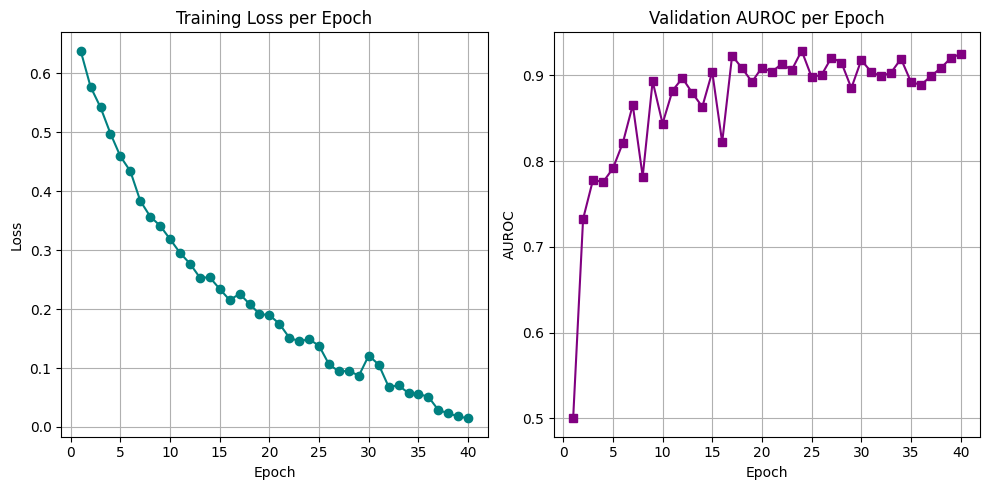

In [15]:
def plot_training_metrics(losses, aurocs):
    epochs = range(1, len(losses) + 1)
    plt.figure(figsize=(10, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', color='teal')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot AUROC
    plt.subplot(1, 2, 2)
    plt.plot(epochs, aurocs, marker='s', color='purple')
    plt.title('Validation AUROC per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_metrics(losses, aurocs)

In [16]:
%%time

# Evaluate on test set
test_loader = DataLoader(ICUTimeSeriesDataset(X_test, y_test), batch_size=batch_size, shuffle=False)
test_preds, test_targets = trainer.evaluate(test_loader)

# Classification report
trainer.classification_report(test_preds, test_targets)


Classification Report @ Threshold = 0.5:
              precision    recall  f1-score   support

           0     0.9933    0.8652    0.9249       690
           1     0.8806    0.9942    0.9340       690

    accuracy                         0.9297      1380
   macro avg     0.9370    0.9297    0.9294      1380
weighted avg     0.9370    0.9297    0.9294      1380

CPU times: user 10min 15s, sys: 6min 55s, total: 17min 11s
Wall time: 23.9 s


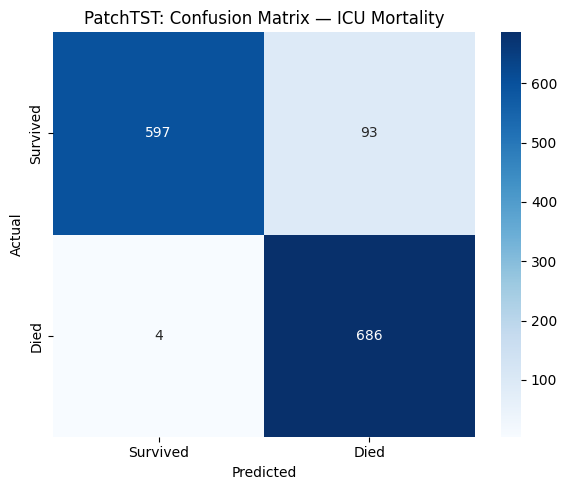

In [20]:
patchTST_cm = confusion_matrix(test_targets, test_preds)

def plot_confusion_matrix(cm, title='PatchTST'):
    labels = ['Survived', 'Died']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{title}: Confusion Matrix — ICU Mortality')
    plt.tight_layout()
    plt.show()

plot_confusion_matrix(patchTST_cm)

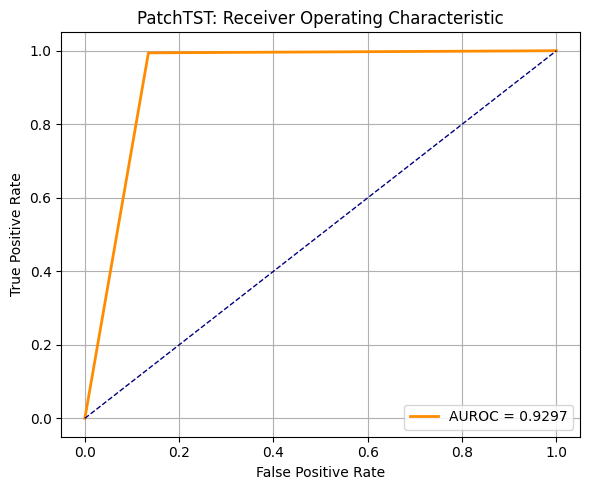

In [18]:
def plot_roc_curve(targets, preds, title='PatchTST'):
    fpr, tpr, thresholds = roc_curve(targets, preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUROC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}: Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_roc_curve(test_targets, test_preds)

## References:

Baumgartner, A., Molani, S., Wei, Q., & Hadlock, J. (2022). *Imputing Missing Observations with Time Sliced Synthetic Minority Oversampling Technique*. ArXiv.org. https://arxiv.org/abs/2201.05634

Nie, Y., Nguyen, N., Sinthong, P., & Kalagnanam, J. (2023). *A TIME SERIES IS WORTH 64 WORDS: LONG-TERM FORECASTING WITH TRANSFORMERS*. https://arxiv.org/pdf/2211.14730

PyTorch Contributors. (2022, July 20). *Building Models with PyTorch*. Pytorch.org. https://docs.pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html

